In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array,array_to_img
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, DepthwiseConv2D, LeakyReLU, Add, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from skimage.transform import resize
from PIL import Image, ImageOps

import glob, os, random

In [19]:
base_path = 'Images/Train/'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

9163


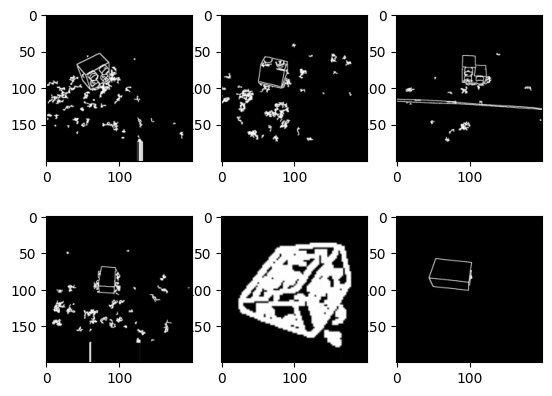

In [20]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    
    img = img_to_array(img, dtype=np.uint8)
    
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True).astype(np.uint8)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [21]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1./255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 8256 images belonging to 20 classes.
Found 907 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [22]:
inputs = Input(shape=(200, 200, 1))

net = Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Add()([shortcut, net])

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=128, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(128, activation='relu')(net)

net = Dense(64, activation='relu')(net)

outputs = Dense(20, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 200, 200, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)     (None, 200, 200, 64  0           ['conv2d_16[0][0]']              
                                )                                                           

In [23]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
258/258 [==============================] - 289s 1s/step - loss: 2.3939 - acc: 0.1875 - val_loss: 2.1676 - val_acc: 0.2536
Epoch 2/20
258/258 [==============================] - 245s 949ms/step - loss: 1.7274 - acc: 0.3710 - val_loss: 1.7735 - val_acc: 0.3903
Epoch 3/20
258/258 [==============================] - 236s 916ms/step - loss: 1.4536 - acc: 0.4695 - val_loss: 2.2968 - val_acc: 0.3627
Epoch 4/20
258/258 [==============================] - 236s 914ms/step - loss: 1.2862 - acc: 0.5213 - val_loss: 1.8782 - val_acc: 0.4267
Epoch 5/20
258/258 [==============================] - 248s 961ms/step - loss: 1.1497 - acc: 0.5792 - val_loss: 1.4414 - val_acc: 0.5314
Epoch 6/20
258/258 [==============================] - 237s 918ms/step - loss: 1.0416 - acc: 0.6240 - val_loss: 0.9764 - val_acc: 0.6615
Epoch 7/20
258/258 [==============================] - 234s 906ms/step - loss: 0.9628 - acc: 0.6462 - val_loss: 1.1297 - val_acc: 0.6307
Epoch 8/20
258/258 [==============================]

In [24]:
model.fit(train_generator, epochs=1, validation_data=validation_generator)


258/258 [==============================] - 259s 1s/step - loss: 0.5021 - acc: 0.8144 - val_loss: 0.5455 - val_acc: 0.8258


In [25]:
model.save_weights('WeightsTest')
print('Model Saved!')

Model Saved!


(95, 116)
(200, 200, 1)
(1, 200, 200, 1)
1/1 [==============================] - 0s 237ms/step
[[1.9985976e-08 1.2475864e-11 1.6024002e-11 7.0406602e-12 2.6820259e-15
  4.3665705e-12 7.0646027e-05 1.9375799e-12 3.8985732e-16 8.6092018e-03
  9.3648414e-06 9.1826417e-02 7.6300367e-03 8.9182740e-01 2.4334162e-05
  3.3195224e-09 9.4497729e-08 2.5323550e-06 7.8004614e-10 6.3477956e-13]]
Plate_1x2_Grill
13


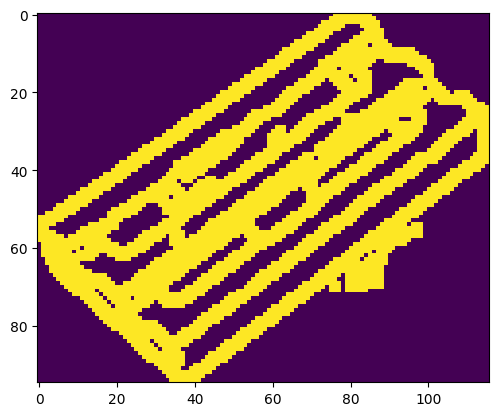

In [26]:
#savedModel = model.load_weights('Weights2')
import cv2
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #converting to gray scale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #applying canny edge detection
    edged = cv2.Canny(gray, 10,100)

    #finding contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    idx = 0
    for c in contours:
	    x,y,w,h = cv2.boundingRect(c)
	    if w>50 and h>50:
		    idx+=1
		    new_img=image[y:y+h,x:x+w]
    blurred = cv2.GaussianBlur(new_img, (1, 1), 0)
    edged = cv2.Canny(blurred,10, 100, apertureSize= 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edged, kernel, iterations=1)
    return (dilate)
    #return image

test=get_image('test2.jpg')
img = img_to_array(test, dtype=np.float32)
print(test.shape)
plt.imshow(test)

test=resize_pad(img)
print(test.shape)
test = test.reshape((1,) + test.shape)
print(test.shape)
test = test_datagen.flow(test, batch_size=32, shuffle=False)

predictions=model.predict(test)
print(predictions)

pred=np.argmax(predictions)
print(labels[pred])
print(pred)